## About Dataset
[Diatom Dataset from Kaggle](https://www.kaggle.com/datasets/huseyingunduz/diatom-dataset)

The dataset contains **2,197 color images** with **3,027 diatoms** from **68 species**. The resolution of the images is **2112×1584 pixels**.

## 1. Import Required Packages

In [509]:
import os
from collections import OrderedDict

import xml.etree.ElementTree as ET

import PIL

import numpy as np
import matplotlib.pyplot as plt

## 2. Dataset Preparation and Visualization

In [510]:
diatom_dataset_root_dir = os.path.join("..", "data", "diatom_dataset")

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

print(os.listdir(diatom_images_dir)[:10])
print(os.listdir(diatom_xmls_dir)[:10])

['1804.png', '1810.png', '1186.png', '412.png', '374.png', '1838.png', '360.png', '406.png', '1192.png', '1179.png']
['162.xml', '604.xml', '2699.xml', '88.xml', '638.xml', '1435.xml', '1353.xml', '1347.xml', '2128.xml', '1421.xml']


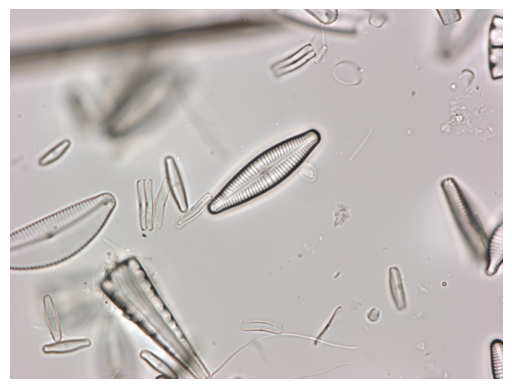

In [511]:
def load_image(filename):
  pil_img = PIL.Image.open(os.path.join(diatom_images_dir, filename))
  return np.array(pil_img)

img = load_image(filename="3.png")

plt.imshow(img)
plt.axis(False)
plt.show()

In [512]:
def parse_xml(filename):
  tree = ET.parse(os.path.join(diatom_xmls_dir, filename))
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  width = int(root.find("size/width").text)
  height = int(root.find("size/height").text)

  objs = []

  for obj in root.findall("objects/object"):
    class_id = int(obj.find("id").text)
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    xcenter = (xmax - xmin) // 2
    ycenter = (ymax - ymin) // 2

    objs.append({
      "class_id": class_id,
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "width": width,
    "height": height,
    "objects": objs
  }

parse_xml("25.xml")

{'filename': '25.png',
 'width': 2112,
 'height': 1584,
 'objects': [{'class_id': 142,
   'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_id': 1,
   'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [513]:
classes = {}
class_count = {}

bbox_areas = []
aspect_ratios = []

xcenters = []
ycenters = []

object_per_images = []

xmls = [parse_xml(xml_file) for xml_file in os.listdir(diatom_xmls_dir)]

for xml in xmls:
  for obj in xml["objects"]:
    class_id, class_name = obj["class_id"], obj["class_name"]
    xmin, xmax = obj["xmin"], obj["xmax"]
    ymin, ymax = obj["ymin"], obj["ymax"]
    
    width, height = xmax - xmin, ymax - ymin
    xcenter, ycenter = (xmax + xmin) // 2, (ymax + ymin) // 2

    classes[class_id] = class_name
    class_count[class_id] = class_count.get(class_id, 0) + 1

    bbox_areas.append(width * height)
    aspect_ratios.append(width / height)

    xcenters.append(xcenter)
    ycenters.append(ycenter)

  object_per_images.append(len(xml["objects"]))

sorted_items = sorted(class_count.items(), key=lambda x: x[1], reverse=True)

class_count = OrderedDict((i, count) for i, (_, count) in enumerate(sorted_items))
classes = OrderedDict((i, classes[cid]) for i, (cid, _) in enumerate(sorted_items))
class_to_idx = OrderedDict((classes[i], i) for i in classes)

bbox_areas = np.array(bbox_areas)
aspect_ratios = np.array(aspect_ratios)

object_per_images = np.array(object_per_images)

In [514]:
def print_top_n_classes(top_n=10):
  print(f"Top-{top_n} classes")
  print("Rank  Id   Class Name                                Count")

  for i, (class_id, count) in enumerate(class_count.items()):
    rank = i + 1

    print(f"#{rank:<3d} ({class_id:3d}) {classes[class_id]:40}: {count}")

    if rank == top_n:
      break

print_top_n_classes()

Top-10 classes
Rank  Id   Class Name                                Count
#1   (  0) Gomphonema olivaceum                    : 386
#2   (  1) Navicula cryptotenella                  : 272
#3   (  2) Fragilaria recapitellata                : 184
#4   (  3) Encyonema silesiacum                    : 182
#5   (  4) Navicula reichardtiana                  : 165
#6   (  5) Planothidium lanceolatum                : 132
#7   (  6) Gomphonema tergestinum                  : 85
#8   (  7) Navicula cryptotenelloides              : 77
#9   (  8) Rhoicosphenia abbreviata                : 77
#10  (  9) Meridion circulare                      : 65


In [515]:
list(class_count.items())[:10]

[(0, 386),
 (1, 272),
 (2, 184),
 (3, 182),
 (4, 165),
 (5, 132),
 (6, 85),
 (7, 77),
 (8, 77),
 (9, 65)]

In [516]:
list(classes.items())[:10]

[(0, 'Gomphonema olivaceum'),
 (1, 'Navicula cryptotenella'),
 (2, 'Fragilaria recapitellata'),
 (3, 'Encyonema silesiacum'),
 (4, 'Navicula reichardtiana'),
 (5, 'Planothidium lanceolatum'),
 (6, 'Gomphonema tergestinum'),
 (7, 'Navicula cryptotenelloides'),
 (8, 'Rhoicosphenia abbreviata'),
 (9, 'Meridion circulare')]

In [517]:
list(class_to_idx.items())[:10]

[('Gomphonema olivaceum', 0),
 ('Navicula cryptotenella', 1),
 ('Fragilaria recapitellata', 2),
 ('Encyonema silesiacum', 3),
 ('Navicula reichardtiana', 4),
 ('Planothidium lanceolatum', 5),
 ('Gomphonema tergestinum', 6),
 ('Navicula cryptotenelloides', 7),
 ('Rhoicosphenia abbreviata', 8),
 ('Meridion circulare', 9)]

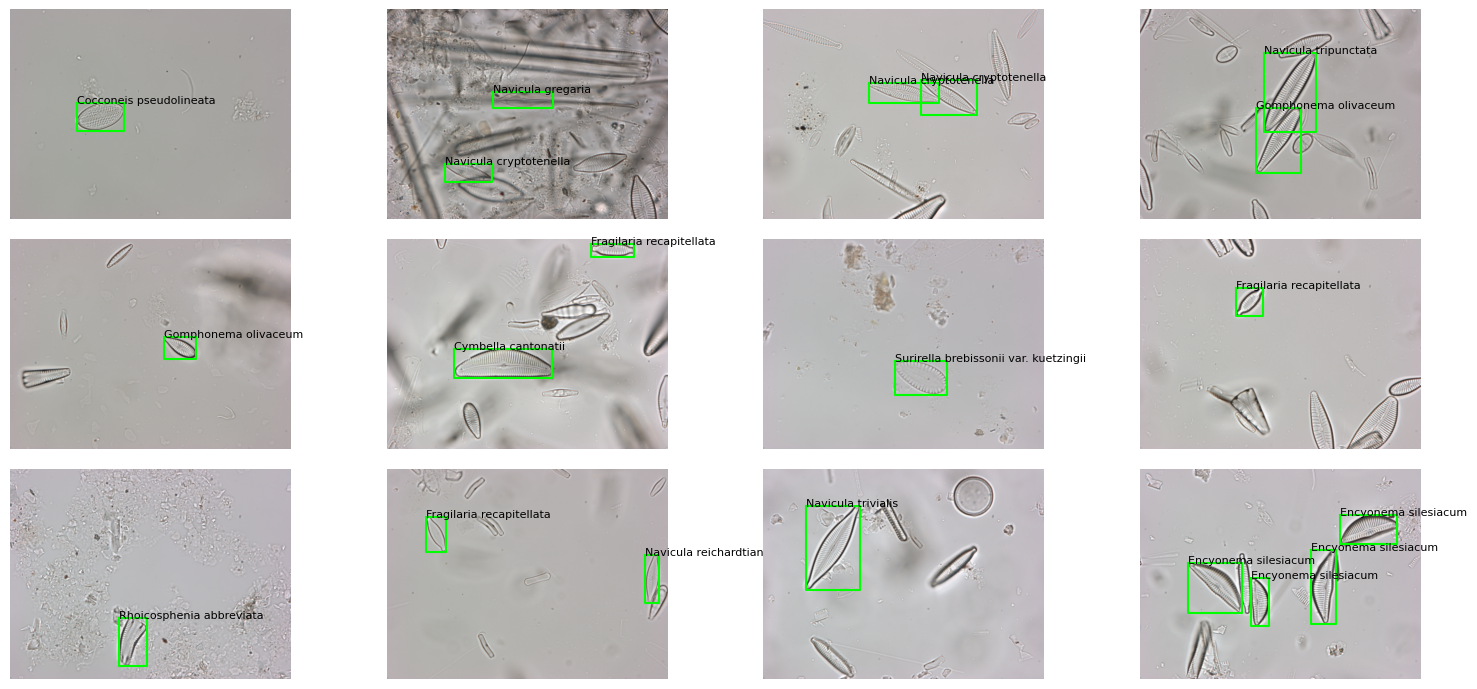

In [518]:
def plot_random_samples(n_rows=3, n_cols=4):
  n_samples = n_rows * n_cols

  samples = np.random.choice(xmls, n_samples)

  plt.figure(figsize=(15, 7))

  for i in range(n_samples):
    sample = samples[i]

    plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(load_image(filename=sample["filename"]))

    for obj in sample["objects"]:
      class_name = obj["class_name"]
      xmin, xmax = obj["xmin"], obj["xmax"]
      ymin, ymax = obj["ymin"], obj["ymax"]

      plt.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        color="lime"
      )
      plt.text(xmin, ymin, class_name, color="black", fontsize=8)

    plt.axis(False)

  plt.tight_layout()
  plt.show()

plot_random_samples()

## 3. Class Distribution Analysis

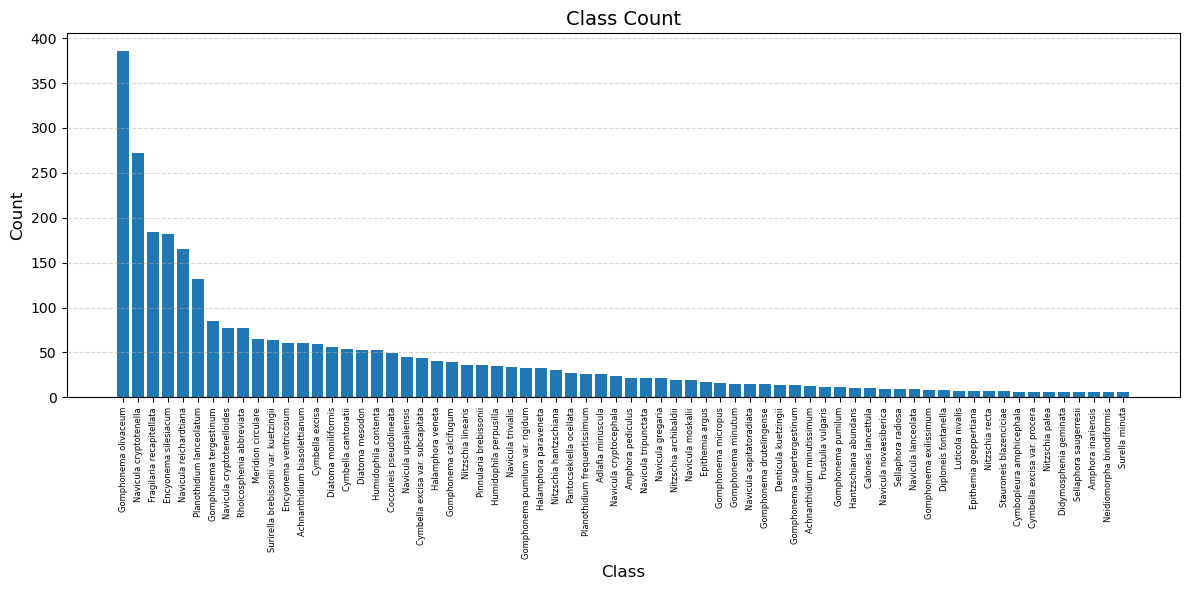

In [527]:
plt.figure(figsize=(12, 6))
plt.bar(class_count.keys(), class_count.values())

plt.title("Class Count", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

xticks = list(classes.keys())
xtick_labels = [classes[x] for x in xticks]

plt.xticks(xticks, xtick_labels, rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

## 4. Objects per Image

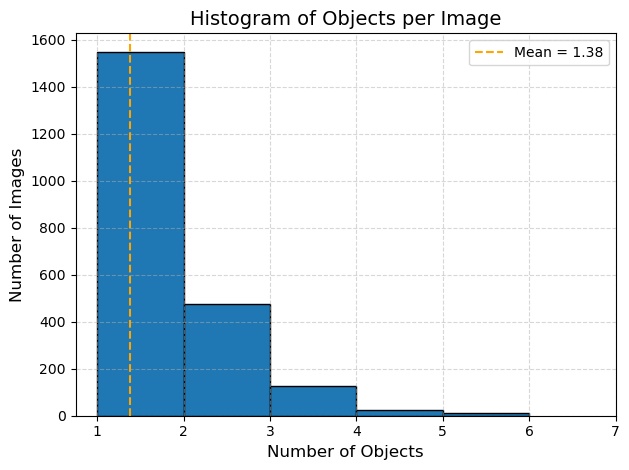

In [ ]:
object_per_image_mean = object_per_images.mean()

plt.hist(object_per_images, bins=np.arange(1, max(object_per_images)), edgecolor='black')

plt.title("Histogram of Objects per Image", fontsize=14)
plt.xlabel("Number of Objects", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(np.arange(1, max(object_per_images) + 1))
plt.axvline(object_per_image_mean, color="orange", linestyle="--", label=f"Mean = {object_per_image_mean:.2f}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

## 5. Bounding Box Size Analysis

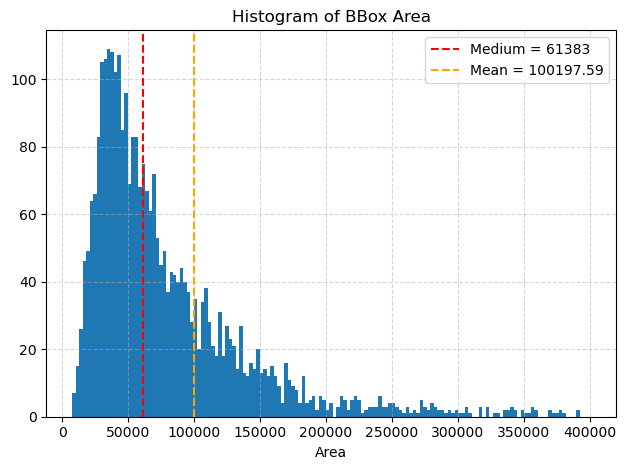

In [ ]:
bbox_min, bbox_max = bbox_areas.min(), bbox_areas.max()

medium_idx = bbox_areas.argsort()[len(bbox_areas) // 2]
bbox_area_medium = bbox_areas[medium_idx]

bbox_area_mean = bbox_areas.mean()

plt.hist(bbox_areas, bins=np.linspace(bbox_min, 0.4e6, 150))

plt.title("Histogram of BBox Area")
plt.xlabel("Area")
plt.axvline(bbox_area_medium, color="red", linestyle="--", label=f"Medium = {bbox_area_medium}")
plt.axvline(bbox_area_mean, color="orange", linestyle="--", label=f"Mean = {bbox_area_mean:.2f}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

## 6. Aspect Ratio Analysis

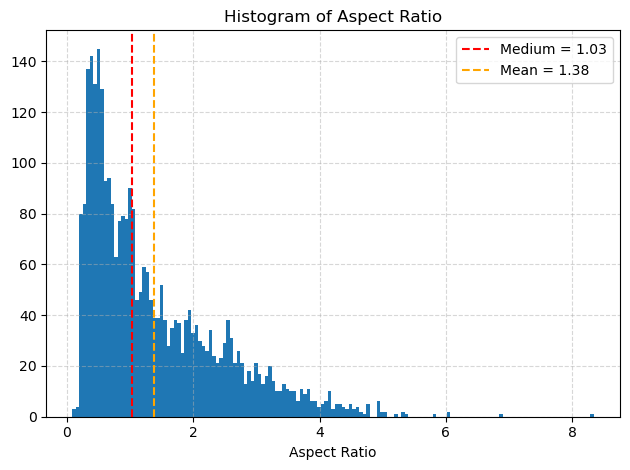

In [ ]:
aspect_ratio_min, aspect_ratio_max = aspect_ratios.min(), aspect_ratios.max()

medium_idx = aspect_ratios.argsort()[len(bbox_areas) // 2]
medium_aspect_ratios = aspect_ratios[medium_idx]

mean_aspect_ratios = aspect_ratios.mean()

plt.hist(aspect_ratios, bins=np.linspace(aspect_ratio_min, aspect_ratio_max, 150))

plt.title("Histogram of Aspect Ratio")
plt.xlabel("Aspect Ratio")
plt.axvline(medium_aspect_ratios, color="red", linestyle="--", label=f"Medium = {medium_aspect_ratios:.2f}")
plt.axvline(mean_aspect_ratios, color="orange", linestyle="--", label=f"Mean = {mean_aspect_ratios:.2f}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Spatial Distribution of Objects

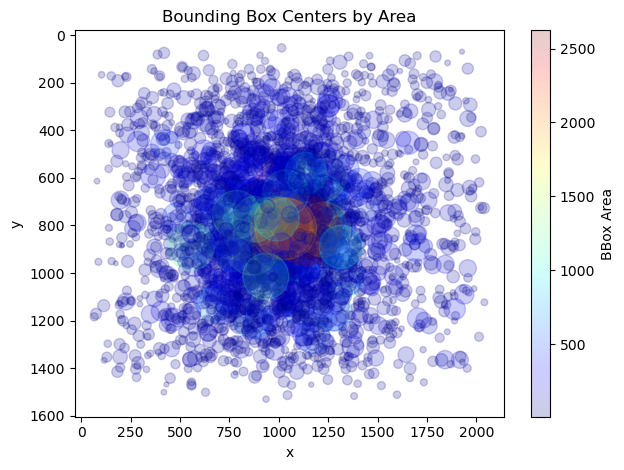

In [ ]:
plt.scatter(xcenters, ycenters, s=bbox_areas/1000, c=bbox_areas/1000, cmap="jet", alpha=0.2)

plt.title("Bounding Box Centers by Area")
plt.colorbar(label="BBox Area")
plt.xlabel("x")
plt.ylabel("y")

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()